# **1. Build an AutoEncoder on the MNIST dataset**

In [4]:
from keras.models import Model, Sequential
from keras.datasets import fashion_mnist
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.applications import vgg16
from keras.layers import Input, Dense,Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Reshape, Embedding, LSTM, GlobalMaxPooling1D

In [5]:
# load fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [5]:
# rescale the image 
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255 
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

In [6]:
x_train.shape

(60000, 28, 28, 1)

In [14]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss="binary_crossentropy")

In [15]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 87s 1ms/step - loss: 0.3719 - val_loss: 0.3306
Epoch 2/10
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3235 - val_loss: 0.3221
Epoch 3/10
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3132 - val_loss: 0.3111
Epoch 4/10
60000/60000 [==============================] - 84s 1ms/step - loss: 0.3074 - val_loss: 0.3054
Epoch 5/10
60000/60000 [==============================] - 89s 1ms/step - loss: 0.3043 - val_loss: 0.3039
Epoch 6/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.3020 - val_loss: 0.3024
Epoch 7/10
60000/60000 [==============================] - 85s 1ms/step - loss: 0.3006 - val_loss: 0.3030
Epoch 8/10
60000/60000 [==============================] - 85s 1ms/step - loss: 0.2991 - val_loss: 0.3010
Epoch 9/10
60000/60000 [==============================] - 87s 1ms/step - loss: 0.2980 - val_loss: 0.2944
Epoch

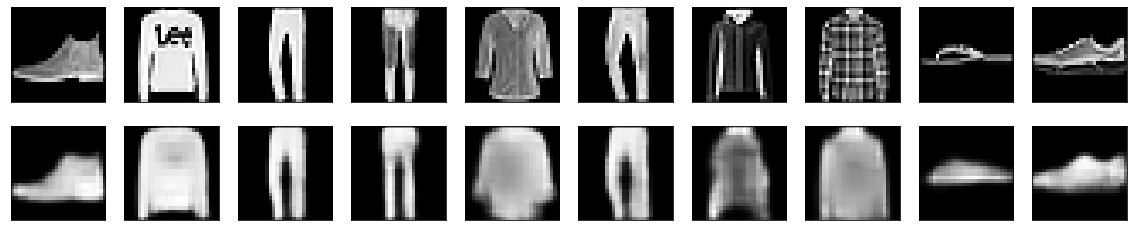

In [17]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# **2. Image Classification**

1. CNN

In [18]:
from keras.utils import to_categorical
#one-hot encode target column
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [21]:
from keras.optimizers import SGD
def define_model():
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(10, activation='softmax'))
        # compile model
        opt = SGD(lr=0.01, momentum=0.9)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

In [24]:
cnn = define_model()
cnn.fit(x_train, Y_train,
          batch_size=64,
          epochs=8,
          validation_data=(x_test, Y_test),verbose = 0 )

In [26]:
# Evaluate Model 
result = cnn.evaluate(x_test, Y_test)
print('Test loss:', result[0])
print('Test accuracy:', result[1])

10000/10000 [==============================] - 2s 213us/step
Test loss: 0.26623026064634325
Test accuracy: 0.9079999923706055


### 2. Transfer Learning

In [19]:
from keras.applications import VGG16
from keras.applications import ResNet50
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(50,50,3))
transfer_model = Sequential()
transfer_model.add(conv_base)
transfer_model.add(Flatten())
transfer_model.add(Dense(128, activation="relu"))
transfer_model.add(Dropout(0.3))
transfer_model.add(Dense(10, activation="softmax"))   
conv_base.trainable = False
transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 14,781,642
Trainable params: 66,954
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
from keras.utils import to_categorical
#load the data
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

x_train = np.dstack([x_train] * 3)
x_test = np.dstack([x_test] * 3)

In [8]:
from keras.preprocessing.image import img_to_array, array_to_img
x_train = x_train.reshape(-1, 28, 28, 3)
x_test = x_test.reshape (-1, 28, 28, 3)
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((50,50))) for im in x_train])/255.
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((50,50))) for im in x_test])/255.

In [9]:
x_train.shape, x_test.shape

((60000, 50, 50, 3), (10000, 50, 50, 3))

In [21]:
conv_base.trainable = False
transfer_model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["acc"])

In [22]:
history = transfer_model.fit(x_train, Y_train,
          epochs=5,
          batch_size=64,
          validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 1252s 23ms/step - loss: 0.7107 - acc: 0.7514 - val_loss: 0.5475 - val_acc: 0.7997
Epoch 2/5
54000/54000 [==============================] - 1275s 24ms/step - loss: 0.5236 - acc: 0.8128 - val_loss: 0.4735 - val_acc: 0.8253
Epoch 3/5
54000/54000 [==============================] - 1473s 27ms/step - loss: 0.4825 - acc: 0.8264 - val_loss: 0.4477 - val_acc: 0.8343
Epoch 4/5
54000/54000 [==============================] - 1281s 24ms/step - loss: 0.4571 - acc: 0.8336 - val_loss: 0.4366 - val_acc: 0.8393
Epoch 5/5
54000/54000 [==============================] - 1284s 24ms/step - loss: 0.4414 - acc: 0.8384 - val_loss: 0.4282 - val_acc: 0.8432


In [24]:
# Evaluate Model 
result = transfer_model.evaluate(x_test, Y_test)
print('Test loss:', result[0])
print('Test accuracy:', result[1])

10000/10000 [==============================] - 227s 23ms/step
Test loss: 0.44428773880004885
Test accuracy: 0.8410000205039978


# 3. Text Classification

1. LSTM

In [25]:
import pandas as pd

In [102]:
df= pd.read_csv('tweets_with_labels.csv',sep='\t')
df.head(5)

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [44]:
# pre-process the data
import preprocessor as p
import re 
p.set_options(p.OPT.URL, p.OPT.MENTION,p.OPT.SMILEY,p.OPT.RESERVED,p.OPT.EMOJI,)
def clean_tweet (i):  
    content_only= p.clean(i)
    remove_punc = re.sub(r'[^a-zA-Z0-9\s]', ' ', content_only)
    return remove_punc
df['tweet_cleaned'] = [clean_tweet(i) for i in df['tweet']]

In [45]:
# turn the sum of all rows into 1 in order to fit in softmax
df['sum']= df.iloc[:,2:].sum(axis=1)
df_c= df[['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11',
       'k12', 'k13', 'k14', 'k15']].div(df['sum'],axis=0)

In [46]:
# check if above is succssful
print(df.shape)
print(df[(df_c.sum(axis=1)-1)<0.001].shape)

(77946, 19)
(77946, 19)


In [48]:
len_tweet = []
for i in df['tweet']:
    length = len(i.split(' '))
    len_tweet.append(length)
max(len_tweet)

59

In [52]:
from keras import preprocessing

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 4000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 60
EMBEDDING_DIM = 64

tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

In [53]:
# how many unique tokens for cleaned tweets?
tokenizer.fit_on_texts(df['tweet_cleaned'].values)
word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

Found 42127 unique tokens.


In [54]:
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (77946, 60)


In [55]:
Y = df_c[['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11',
       'k12', 'k13', 'k14', 'k15']].values

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 2)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(54562, 60) (54562, 15)
(23384, 60) (23384, 15)


In [59]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding,SpatialDropout1D,LSTM

txt_1 = Sequential()
txt_1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_test.shape[1]))
txt_1.add(SpatialDropout1D(0.2))
txt_1.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
txt_1.add(Dense(15, activation='softmax'))
txt_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
epochs = 8
batch_size = 64

history = txt_1.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 49105 samples, validate on 5457 samples
Epoch 1/8
49105/49105 [==============================] - 62s 1ms/step - loss: 1.0144 - accuracy: 0.7881 - val_loss: 0.8930 - val_accuracy: 0.8184
Epoch 2/8
49105/49105 [==============================] - 61s 1ms/step - loss: 0.8782 - accuracy: 0.8203 - val_loss: 0.8473 - val_accuracy: 0.8274
Epoch 3/8
49105/49105 [==============================] - 60s 1ms/step - loss: 0.8332 - accuracy: 0.8279 - val_loss: 0.8268 - val_accuracy: 0.8287
Epoch 4/8
49105/49105 [==============================] - 59s 1ms/step - loss: 0.8085 - accuracy: 0.8307 - val_loss: 0.8171 - val_accuracy: 0.8334
Epoch 5/8
49105/49105 [==============================] - 59s 1ms/step - loss: 0.7909 - accuracy: 0.8361 - val_loss: 0.8122 - val_accuracy: 0.8378
Epoch 6/8
49105/49105 [==============================] - 68s 1ms/step - loss: 0.7775 - accuracy: 0.8383 - val_loss: 0.8109 - val_accuracy: 0.8360
Epoch 7/8
49105/49105 [==============================] - 67s 1ms/step - los

In [62]:
accr = txt_1.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

23384/23384 [==============================] - 11s 462us/step
Test set
  Loss: 0.828
  Accuracy: 0.831


2. CNN

In [89]:
from keras.layers import Dropout, Conv1D,GlobalMaxPool1D
txt_c1 = Sequential()
txt_c1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_test.shape[1]))
txt_c1.add(Dropout(0.2))
txt_c1.add(Conv1D(64, 3, padding='valid', activation='relu', strides=1))
txt_c1.add(GlobalMaxPool1D())
txt_c1.add(Dense(64,activation='relu'))
txt_c1.add(Dense(15, activation='softmax'))

adam = optimizers.Adam(beta_1=0.9, beta_2=0.999, amsgrad=False)
txt_c1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [90]:
epochs = 8
batch_size = 64

history2 = txt_c1.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 49105 samples, validate on 5457 samples
Epoch 1/8
49105/49105 [==============================] - 16s 330us/step - loss: 1.1689 - accuracy: 0.7252 - val_loss: 0.8724 - val_accuracy: 0.8252
Epoch 2/8
49105/49105 [==============================] - 14s 292us/step - loss: 0.8447 - accuracy: 0.8245 - val_loss: 0.8347 - val_accuracy: 0.8351
Epoch 3/8
49105/49105 [==============================] - 14s 285us/step - loss: 0.8054 - accuracy: 0.8321 - val_loss: 0.8146 - val_accuracy: 0.8397
Epoch 4/8
49105/49105 [==============================] - 14s 287us/step - loss: 0.7770 - accuracy: 0.8379 - val_loss: 0.8101 - val_accuracy: 0.8393
Epoch 5/8
49105/49105 [==============================] - 14s 288us/step - loss: 0.7578 - accuracy: 0.8445 - val_loss: 0.8148 - val_accuracy: 0.8351
Epoch 6/8
49105/49105 [==============================] - 14s 289us/step - loss: 0.7408 - accuracy: 0.8479 - val_loss: 0.8165 - val_accuracy: 0.8310
Epoch 7/8
49105/49105 [==============================] - 14s 28

In [91]:
accr = txt_c1.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

23384/23384 [==============================] - 2s 98us/step
Test set
  Loss: 0.850
  Accuracy: 0.818


### 3. Comparison

On test set, both models performs well and there's little overfitting. The RNN model slightly outperforms CNN
- RNN test accuracy = 0.831
- CNN test accuracy = 0.818

On training set, RNN also outperforms CNN, especially on validation set. We can plot the accuracy below

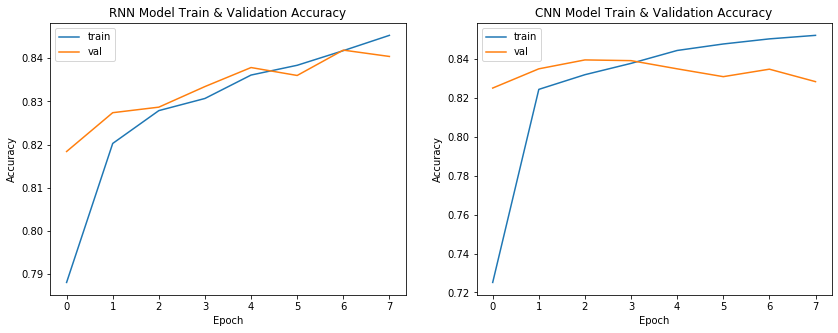

In [100]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('RNN Model Train & Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('CNN Model Train & Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.show()